<a href="https://colab.research.google.com/github/vikashbabukk/Yulu-case-study-Hypothesis-Testing/blob/main/yulu_hypothesis_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro
Yulu is India’s leading micro-mobility service provider, which offers unique vehicles for the daily commute. Starting off as a mission to eliminate traffic congestion in India, Yulu provides the safest commute solution through a user-friendly mobile app to enable shared, solo and sustainable commuting.


Yulu wants to understand:

Which variables are significant in predicting the demand for shared electric cycles in the Indian market?

How well those variables describe the electric cycle demands



```
data

datetime: datetime
season: season (1: spring, 2: summer, 3: fall, 4: winter)
holiday: whether day is a holiday or not
workingday: if day is neither weekend nor holiday is 1, otherwise is 0.
weather:
1: Clear, Few clouds, partly cloudy, partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
temp: temperature in Celsius
atemp: feeling temperature in Celsius
humidity: humidity
windspeed: wind speed
casual: count of casual users
registered: count of registered users
count: count of total rental bikes including both casual and registered

```



# Let's load and clean the data

In [ ]:
# Importing required libraries -
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ttest_ind # T-test for independent samples
from scipy.stats import shapiro # Shapiro-Wilk’s test for Normality
from scipy.stats import levene # Levene's test for Equality of Variance
from scipy.stats import f_oneway # One-way ANOVA
from scipy.stats import chi2_contingency # Chi-square test of independence

In [ ]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/file/d/1o94fXnmvrx6jRgI6S-SeZ3tfnKjCDY0i/view?usp=sharing'

id = link.split("/")[-2]

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('bike_sharing.csv')

In [ ]:
# Loading the dataset -
df=pd.read_csv('bike_sharing.csv')
df.sample(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
2850,2011-07-07 16:00:00,3,0,1,1,35.26,38.635,39,15.0013,47,218,265
10030,2012-11-03 07:00:00,4,0,0,2,13.12,15.150,49,16.9979,1,58,59
2559,2011-06-14 13:00:00,2,0,1,1,26.24,31.060,44,15.0013,33,176,209
10769,2012-12-15 03:00:00,4,0,0,2,9.84,14.395,81,0.0000,5,18,23
8866,2012-08-11 19:00:00,3,0,0,2,27.06,29.545,89,7.0015,97,178,275
2860,2011-07-08 02:00:00,3,0,1,2,28.70,33.335,74,11.0014,10,12,22
8446,2012-07-13 07:00:00,3,0,1,2,28.70,32.575,54,0.0000,27,353,380
6448,2012-03-05 22:00:00,1,0,1,1,9.84,10.605,35,22.0028,2,76,78
908,2011-03-02 07:00:00,1,0,1,1,9.02,10.605,64,16.9979,2,108,110
7688,2012-05-19 17:00:00,2,0,0,1,30.34,32.575,30,6.0032,279,347,626


In [ ]:
# Shape of the dataset -
print("No. of rows : ", df.shape[0])

No. of rows :  10886


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


date time is the only object and others are numerical values

In [ ]:
# Checking for null values -
(df.isna().sum() / len(df)) * 100

datetime      0.0
season        0.0
holiday       0.0
workingday    0.0
weather       0.0
temp          0.0
atemp         0.0
humidity      0.0
windspeed     0.0
casual        0.0
registered    0.0
count         0.0
dtype: float64

**Great , we dont have any null values in the data set**

# Let's check for unique value and value counts for few important attributes

In [ ]:
# Checking for duplicate rows -
dup_rows = df[df.duplicated()]
print("No. of duplicate rows: ", dup_rows.shape[0])

No. of duplicate rows:  0


In [ ]:
def dist_check(df, col_name):
  print("Unique values : ", df[col_name].unique())
  print("Value counts : ")
  print(df[col_name].value_counts())


col_list = ['workingday',	'holiday',	'weather', 'season']
for col in col_list:
  print(col, " -")
  dist_check(df, col)
  print("\n")

workingday  -
Unique values :  [0 1]
Value counts : 
1    7412
0    3474
Name: workingday, dtype: int64


holiday  -
Unique values :  [0 1]
Value counts : 
0    10575
1      311
Name: holiday, dtype: int64


weather  -
Unique values :  [1 2 3 4]
Value counts : 
1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64


season  -
Unique values :  [1 2 3 4]
Value counts : 
4    2734
2    2733
3    2733
1    2686
Name: season, dtype: int64




we can see for wether there is only one data point for 4 ,which is very infrequent so we can remove / avoid it.

Other data point looks fine

# Let's try to understand the number of bike rides [count] with respect to other features.

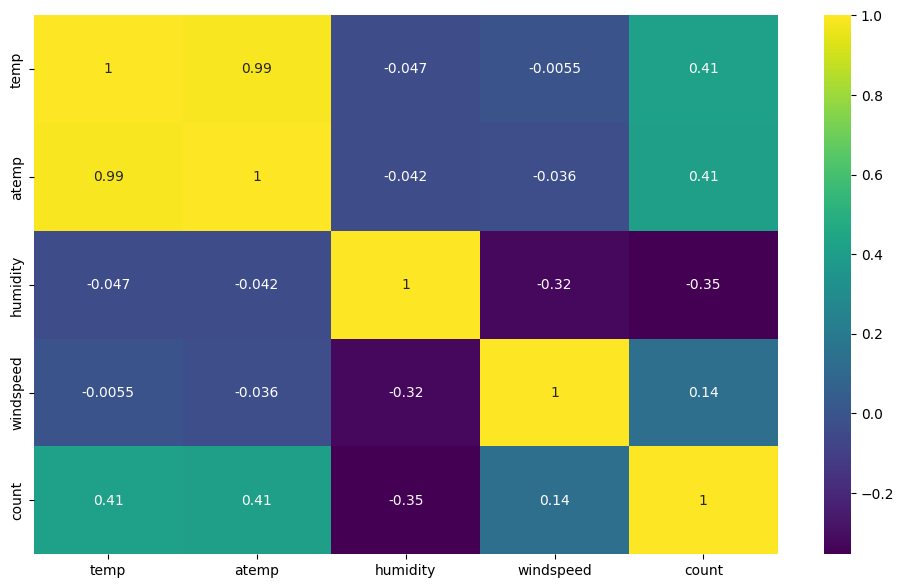

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt  # Matplotlib for plotting
import seaborn as sbn  # Seaborn for statistical data visualization


# Select only the specified numerical columns from the DataFrame
selected_numerical_columns = ['temp', 'atemp', 'humidity','windspeed','count']

numerical_columns = df[selected_numerical_columns]

# Correlation Heatmap -
# Set the size of the figure (plot)
plt.figure(figsize=(12, 7))

# Generate a correlation heatmap using Spearman rank correlation coefficients
# Correlation measures the strength and direction of a linear relationship between two variables.
# Spearman's method is used here, which assesses monotonic (non-linear) relationships.
# numerical_columns.corr(method='spearman') calculates the correlation between selected numerical columns using Spearman's method.
# annot=True adds numeric annotations to each cell in the heatmap.
# cmap='viridis' sets the color map of the heatmap to 'viridis'.
sbn.heatmap(numerical_columns.corr(method='spearman'), annot=True, cmap='viridis')

# Display the heatmap
plt.show()


Correlation measures the strength and direction of a linear relationship between two variables.

why spearman correlation?

In the context of statistical analysis and correlation measures, a monotonic relationship refers to the consistent (but not necessarily constant) direction of association between two variables. Specifically, in a monotonic relationship, as the value of one variable increases (or decreases), the other variable also consistently increases (or decreases), but not necessarily at a constant rate.

A monotonic relationship does not have to be perfectly linear. In a linear relationship, the change in one variable is proportional to the change in the other variable. In contrast, a monotonic relationship only requires a consistent trend in the same direction, but the relationship could be curved or have other shapes.

Here are two types of monotonic relationships:

Monotonic Increasing: As the values of one variable increase, the values of the other variable also increase. This doesn't mean that the rate of increase is constant, but the general trend is upward.

Monotonic Decreasing: As the values of one variable increase, the values of the other variable decrease. Again, the rate of decrease may vary, but the overall trend is downward.

Spearman's rank correlation coefficient is a measure that assesses the strength and direction of monotonic relationships between two variables. It does this by ranking the values of each variable and then calculating the correlation based on the ranks. This makes Spearman correlation robust to outliers and suitable for assessing non-linear relationships

# Insight
*  temp  and atemp i.e feeling temperature are highly corelated with count , which mean people prefer bikes in pleasent temperatures
*   there is an negative correlation between count and humidity which mean humidity increases, there tends to be a decrease in the number of bike rides, and vice versa.



# Outliers detection

In [ ]:
# Dropping highly correlated columns -
dfn = df.drop(columns=['casual', 'registered', 'atemp'])

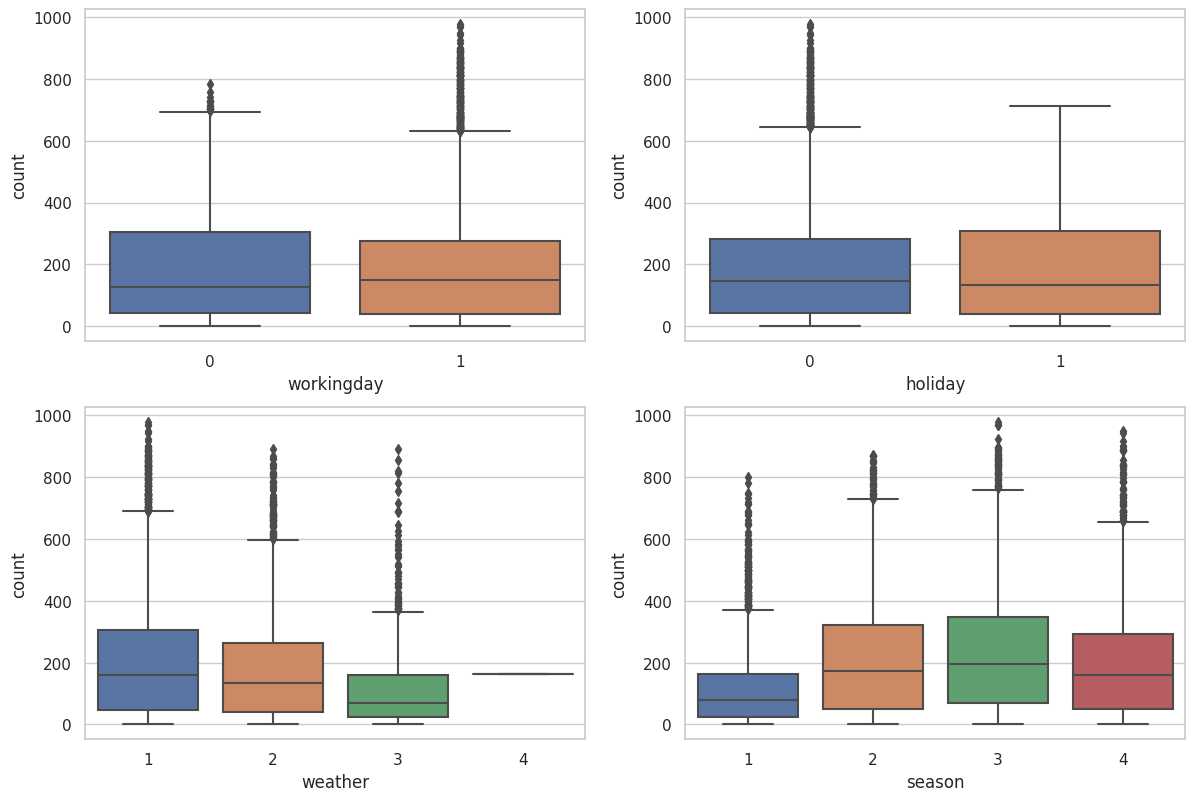

In [ ]:
# Set the style to whitegrid
sbn.set(style="whitegrid")

# Create a figure with a specified size
fig = plt.figure(figsize=(8, 25))

# Adjust the layout to leave space on the right for subplots
fig.subplots_adjust(right=1.5)

# Loop through the columns in col_list and create a box plot for each one
for plot in range(1, len(col_list)+1):
    # Create subplots in a 5x2 grid
    plt.subplot(5, 2, plot)

    # Create a box plot for the current column against the 'count' variable
    sbn.boxplot(x=dfn[col_list[plot-1]], y=dfn['count'])

# Show the plots
plt.show()


From the above box plots we could see lots of outliers but we can call them as extremevalues till we prove them asn an outlier




For Hypotheseis testing we assume the data follows an normal distribution but we could see the data is not normal due to outliers.


# Lets check the distribution of count

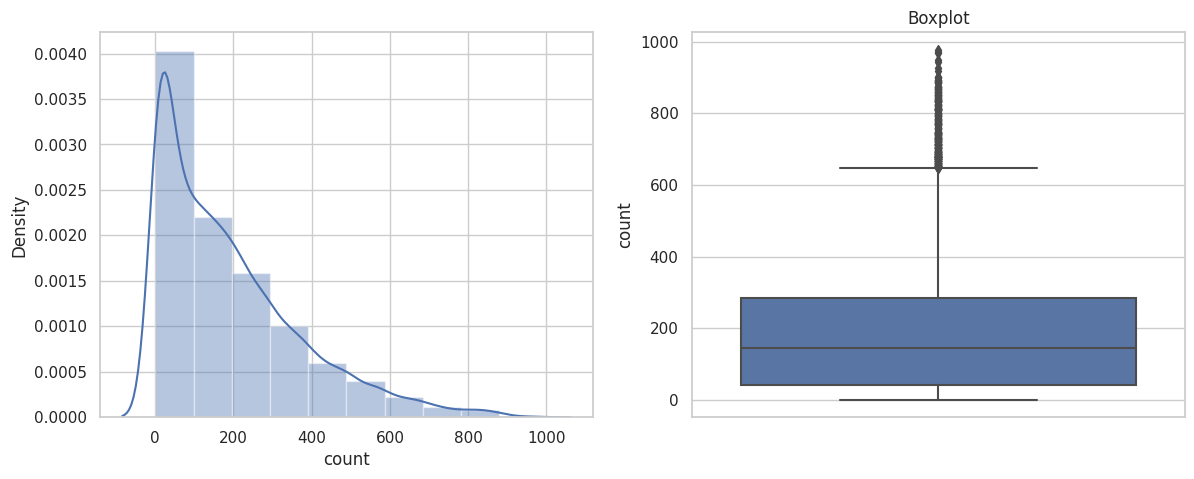

In [ ]:
# Checking distribution of 'count' column -
plt.figure(figsize=(14, 5))

#Histogram
plt.subplot(1, 2, 1)
sbn.distplot(dfn['count'], bins=10)

#Boxplot
plt.subplot(1, 2, 2)
sbn.boxplot(y=dfn['count'])
plt.title('Boxplot')

plt.show()

We can see that outliers are present in the given columns. We need to figure out a way to deal with them before starting with the tests.


We have multiple options available on how to proceed with these outlier values.
we can keep them as it is. if these values make any sense according to the business problem.

In case these outliers are some invalid values which do not make much sense, we can remove them using the IQR.

or

we can apply a log transformation on the data to reduce the effect of these outliers.

The outliers in the given data set are the no. of bike rides per session/day. These values could sometimes be higher than expected due to increase in the crowd on certain days/occasions.

These data values are important for capturing variations in the data. Hence, in this case, the ideal approach of dealing with outliers would be to leave them as it is.

But since the tests that we are going to apply are based on the assumption that the dataset is normal, we will drop those outlier values using the IQR method

In [ ]:
# Outlier Treatment using IQR (not needed but, we can do it) -

q1 = dfn['count'].quantile(0.25)
q3 = dfn['count'].quantile(0.75)
iqr = q3-q1

dfn = dfn[(dfn['count']>(q1-1.5*iqr) ) & (dfn['count']<(q3+1.5*iqr))]

print("No. of rows : ", dfn.shape[0])

No. of rows :  10583


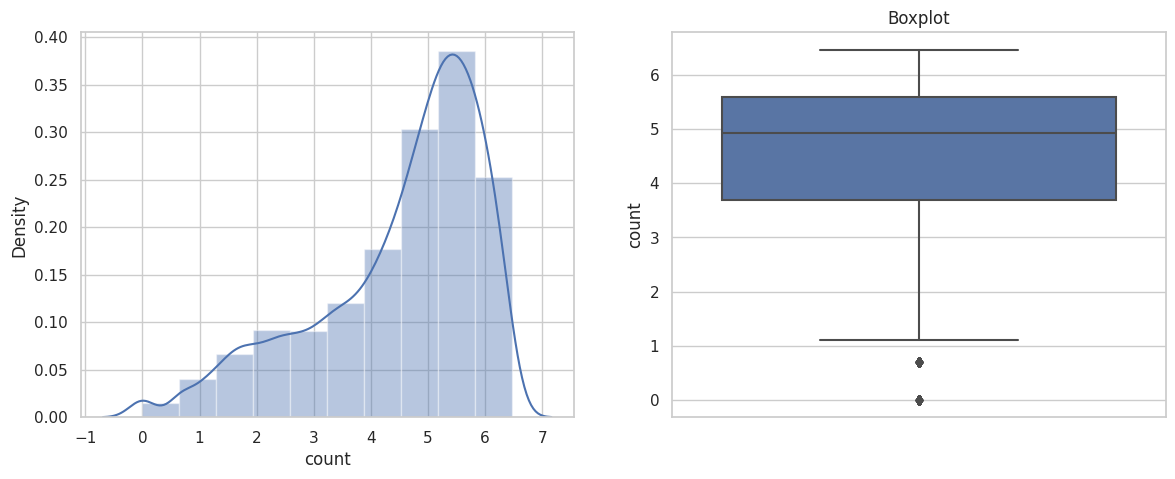

In [ ]:
# Checking distribution after applying log transformation -
plt.figure(figsize=(14, 5))

#Histogram
plt.subplot(1, 2, 1)
sbn.distplot(np.log(dfn['count']), bins=10)

#Boxplot
plt.subplot(1, 2, 2)
sbn.boxplot(y=np.log(dfn['count']))
plt.title('Boxplot')

plt.show()

Now the data is near normal and the effects of outliers are reduced

# Aggregating the total no. of bike rides based on the given factors -

---



# Is there any significant difference between the no. of bike rides on working and non-working days?

In [ ]:
# 1. Workingday -
pd.DataFrame(dfn.groupby('workingday')['count'].describe())

,count,mean,std,min,25%,50%,75%,max
workingday,,,,,,,,
0,3422.0,180.965517,163.782166,1.0,43.0,124.0,295.75,645.0
1,7161.0,173.011591,152.358993,1.0,38.0,143.0,262.00,646.0


The data suggests that, on average, there is a slightly higher number of bike rentals on working days. However, the variability in counts is higher on working days, possibly indicating more diverse patterns of bike usage.

Step 1: Define the null and alternate hypothesis



```
𝐻0: The demand of bikes on weekdays is greater or similar to the demand of bikes on weekend.

𝐻𝑎: The demand of bikes on weekdays is less than the demand of bikes on weekend.

Let 𝜇1 and 𝜇2 be the average no. of bikes rented on weekdays and weekends respectively.

Mathematically, the above formulated hypothesis can be written as:
𝐻0:𝜇1>=𝜇2
𝐻𝑎:𝜇1<𝜇2

```



Step 2: Select an appropriate test



 What is the difference between a t-test and a z-test?

A t-test looks at two sets of data that are different from each other, with no standard deviation or variance.

A z-test views the averages of data sets that are different from each other but have the standard deviation or variance given.

The t test as compared with z test has its advantage for small sample comparison. As n increases, t approaches to z. The advantage of t test disappears, and t distribution simply becomes z distribution.

In other words, with large n, t test is just close to z test and one dosen't lose anything so lets use to use t test.


the standard deviation of the population is not known.

In [ ]:
weekday = dfn[dfn['workingday'] == 1]['count'].sample(2999)
weekend = dfn[dfn['workingday'] == 0]['count'].sample(2999)

 Why do we take same noumber of samples from two different populations for conducting the tests?


* Unequal sample sizes can lead to unequal variances between samples, which affects the assumption of equal variances in t-tests.

* Having both unequal sample sizes and variances dramatically affects the statistical power of a test.


In [ ]:
print('The sample standard deviation of the bike rides on weekday is:', round(weekday.std(), 2))
print('The sample standard deviation of the bike rides on weekend is:', round(weekend.std(), 2))

The sample standard deviation of the bike rides on weekday is: 153.31
The sample standard deviation of the bike rides on weekend is: 163.03


As the sample standard deviations are different, the population standard deviations can be assumed to be different.

This is a one-tailed test concerning two population means from two independent populations. As the population standard deviations are unknown, the two sample independent t-test will be the appropriate test for this problem.

Step 3: Decide the significance level

As given in the problem statement, we select α = 0.05

Step 4: Calculate the p-value

In [ ]:
alpha = 0.05

def result(p_value, alpha):
  if p_value < alpha:
    print(f'As the p-value {p_value} is less than the level of significance, we reject the null hypothesis.')
  else:
    print(f'As the p-value {p_value} is greater than the level of significance, we fail to reject the null hypothesis.')


test_stat, p_value = ttest_ind(weekday, weekend, equal_var=False, alternative='less')
print('The p-value is : ', p_value)

result(p_value, alpha)

The p-value is :  0.3636462064149856
As the p-value 0.3636462064149856 is greater than the level of significance, we fail to reject the null hypothesis.


**Observation:** Since the p-value is greater than the 5% significance level, we fail to reject the null hypothesis. Hence, we have enough statistical evidence to say that the average no. of bike rides during weekdays is greater than or equal to those on weekends.

# Is there any significant difference between the no. of bike rides on regular days and holidays?

In [ ]:
# 2. Holiday -
pd.DataFrame(dfn.groupby('holiday')['count'].describe())

,count,mean,std,min,25%,50%,75%,max
holiday,,,,,,,,
0,10273.0,175.373893,155.957826,1.0,40.0,138.0,269.0,646.0
1,309.0,182.588997,163.766590,1.0,38.0,127.0,304.0,597.0


Step 1: Define the null and alternate hypothesis



```
𝐻0:  The demand of bikes on regular days is greater or similar to the demand of bikes on holidays.

𝐻𝑎:  The demand of bikes on regular days is less than the demand of bikes on holidays.

Let  𝜇1  and  𝜇2  be the average no. of bikes rented on regular days and holidays respectively.

Mathematically, the above formulated hypothesis can be written as:
𝐻0:𝜇1>=𝜇2
𝐻𝑎:𝜇1<𝜇2
```



Step 2: Select an appropriate test

the standard deviation of the population is not known.

In [ ]:
holiday = dfn[dfn['holiday'] == 1]['count'].sample(299)
regular = dfn[dfn['holiday'] == 0]['count'].sample(299)


print('The sample standard deviation of the bike rides on holidays is:', round(holiday.std(), 2))
print('The sample standard deviation of the bike rides on regular days is:', round(regular.std(), 2))

The sample standard deviation of the bike rides on holidays is: 163.88
The sample standard deviation of the bike rides on regular days is: 164.07


As the sample standard deviations are different, the population standard deviations can be assumed to be different.


This is also a one-tailed test concerning two population means from two independent populations. As the population standard deviations are unknown, the two sample independent t-test will be the appropriate test for this problem.

Step 3: Decide the significance level

The significance level (α) is already set to 5% i.e., 0.05

In [ ]:
test_stat, p_value = ttest_ind(regular, holiday, equal_var=False, alternative='less')
print('The p-value is : ', p_value)

result(p_value, alpha)

The p-value is :  0.6310977039882257
As the p-value 0.6310977039882257 is greater than the level of significance, we fail to reject the null hypothesis.


**Observation**: Since the p-value is greater than the 5% significance level, we fail to reject the null hypothesis. Hence, we have enough statistical evidence to say that the average no. of bike rides during regular days is greater than or equal to those on holidays.

# Is the demand of bicycles on rent same for different weather conditions?

In [ ]:
# 3. Weather -

# Remove rows where weather condition is categorized as 4 (infreqentdat point only one)
dfn = dfn[~(dfn['weather'] == 4)]

pd.DataFrame(dfn.groupby('weather')['count'].describe())

,count,mean,std,min,25%,50%,75%,max
weather,,,,,,,,
1,6962.0,187.131140,161.333785,1.0,45.0,153.0,286.0,646.0
2,2770.0,166.117690,146.992422,1.0,39.0,130.0,254.0,646.0
3,850.0,111.862353,121.233389,1.0,23.0,70.5,157.0,646.0


Step 1: Define the null and alternate hypothesis

```


𝐻0:  The average no. of bike rides in different weather conditions are equal.

𝐻𝑎:  The average no. of bike rides in different weather conditions are not equal.

Let  𝜇1  and  𝜇2  be the average no. of bikes rented on weekdays and weekends respectively.
```



Step 2: Select an appropriate test

In [ ]:
w1 = dfn[dfn['weather'] == 1]['count'].sample(750)
w2 = dfn[dfn['weather'] == 2]['count'].sample(750)
w3 = dfn[dfn['weather'] == 3]['count'].sample(750)


In [ ]:
dfn.groupby(['weather'])['count'].describe()

,count,mean,std,min,25%,50%,75%,max
weather,,,,,,,,
1,6962.0,187.131140,161.333785,1.0,45.0,153.0,286.0,646.0
2,2770.0,166.117690,146.992422,1.0,39.0,130.0,254.0,646.0
3,850.0,111.862353,121.233389,1.0,23.0,70.5,157.0,646.0


This is a problem, concerning three independent population means. One-way ANOVA could be the appropriate test here provided normality and equality of variance assumptions are verified.


The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid.

The samples are independent.

Each sample is from a normally distributed population.

The population variance of the groups are all equal.

Now, we will be using the following statistical tests to check the normality and euality of variance of the data set -

For testing of normality, Shapiro-Wilk’s test is applied to the response variable.
For equality of variance, Levene test is applied to the response variable.


# Shapiro-Wilk’s test -

We will test the null hypothesis

>$H_0:$ Count follows normal distribution

against the alternative hypothesis

>$H_a:$ Count doesn't follow normal distribution

In [ ]:
# Assumption 1: Normality

w, p_value = shapiro(dfn['count'].sample(4999))
print('The p-value is : ', p_value)

result(p_value, alpha)

The p-value is :  0.0
As the p-value 0.0 is less than the level of significance, we reject the null hypothesis.


# Levene’s test -


We will test the null hypothesis

>$H_0$: All the count variances are equal

against the alternative hypothesis

>$H_a$: At least one variance is different from the rest

In [ ]:
#Assumption 2: Homogeneity of Variance

stat, p_value = levene(w1, w2, w3)
print('The p-value is : ', p_value)

result(p_value, alpha)

The p-value is :  2.8673092800754276e-16
As the p-value 2.8673092800754276e-16 is less than the level of significance, we reject the null hypothesis.


From these test we found the sample is not normally distributed nor the population variance of the groups are all equal.

# Central Limit Theorem -



* According to this theorem, the distribution of sample means approximates a normal distribution as the sample size gets larger, regardless of the population's distribution.

* In other words, if we find the mean of a large number of independent random variables, the mean
will follow a normal distribution, irrespective of the distribution of the original variables.

* In practice, sample sizes equal to or greater than 30-40 are often considered sufficient for the CLT to hold.

Hence, the sample size being large enough, we don't need to worry about the non-normality of distribution of the data set in hand before applying the tests.

Eventually, as the sample size gets larger, the distribution of sample means will fall into a normal or near normal shape.


Step 3: Decide the significance level

The significance level (α) is already set to 5% i.e., 0.05

In [ ]:
test_stat, p_value = f_oneway(w1, w2, w3)
print('The p-value is : ', p_value)

result(p_value, alpha)

The p-value is :  1.649555098895465e-22
As the p-value 1.649555098895465e-22 is less than the level of significance, we reject the null hypothesis.


**Observation**: Since the p-value is less than the 5% significance level, we reject the null hypothesis. Hence, we have enough statistical evidence to say that the average no. of bike rides in different weather conditions are not equal.

#  Is the demand of bicycles on rent same for different seasons?

In [ ]:
# 4. Season -
pd.DataFrame(dfn.groupby('season')['count'].describe())

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
1,2669.0,112.775946,116.902627,1.0,24.00,78.0,161.00,644.0
2,2633.0,195.653627,166.170802,1.0,45.00,165.0,299.00,646.0
3,2616.0,210.484327,164.055532,1.0,59.75,185.0,323.25,646.0
4,2664.0,184.404655,154.563069,1.0,48.75,154.0,276.25,646.0


#### **Step 1:** Define the null and alternate hypothesis

$H_0:$ The average no. of bike rides in different seasons  are equal.

$H_a:$ The average no. of bike rides in different seasons are not equal.

Step 2: Select an appropriate test

In [ ]:
s1 = dfn[dfn['season'] == 1]['count'].sample(2399)
s2 = dfn[dfn['season'] == 2]['count'].sample(2399)
s3 = dfn[dfn['season'] == 3]['count'].sample(2399)
s4 = dfn[dfn['season'] == 3]['count'].sample(2399)

In [ ]:
dfn.groupby(['season'])['count'].describe()

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
1,2669.0,112.775946,116.902627,1.0,24.00,78.0,161.00,644.0
2,2633.0,195.653627,166.170802,1.0,45.00,165.0,299.00,646.0
3,2616.0,210.484327,164.055532,1.0,59.75,185.0,323.25,646.0
4,2664.0,184.404655,154.563069,1.0,48.75,154.0,276.25,646.0


We have already performed tests for normality and homogeneity of variance. So we will be directly moving onto the One-way ANOVA test.

Step 3: Decide the significance level

The significance level (α) is already set to 5% i.e., 0.05

Step 4: Calculate the p-value

In [ ]:
test_stat, p_value = f_oneway(s1, s2, s3, s4)
print('The p-value is : ', p_value)

result(p_value, alpha)

The p-value is :  1.979682110285218e-143
As the p-value 1.979682110285218e-143 is less than the level of significance, we reject the null hypothesis.


**Observation:** Since the p-value is less than the 5% significance level, we reject the null hypothesis. Hence, we have enough statistical evidence to say that the average no. of bike rides in different seasons are not equal.

# Are the weather conditions significantly different during different seasons?

#### **Step 1:** Define the null and alternate hypothesis

$H_0:$ Weather conditions are independent of the season.

$H_a:$ Weather condition depends on the ongoing season.

Step 2: Select an appropriate test

Although the data values in 'season' and 'weather' columns are numerical, as per our intuition, they still represent different catgories. Hence, we will encode them accordingly before moving onto the tests.

In [ ]:
dict1 = {1: 'Sunny',
         2: 'Cloudy',
         3: 'Rainy'}
dfn['weather_enc'] = dfn['weather'].map(dict1)

In [ ]:
dict2 = {1: 'Summer',
         2: 'Monsoon',
         3: 'Winter',
         4: 'Autumn'}
dfn['season_enc'] = dfn['season'].map(dict2)

Here we will be comparing two different categorical variables, 'season' and 'weather'. So will perform a **Chi-square test.**

In [ ]:
contigency= pd.crosstab(dfn.season_enc, dfn.weather_enc)
contigency

weather_enc,Cloudy,Rainy,Sunny
season_enc,,,
Autumn,787,221,1656
Monsoon,690,223,1720
Summer,714,211,1744
Winter,579,195,1842


<Axes: xlabel='season_enc'>

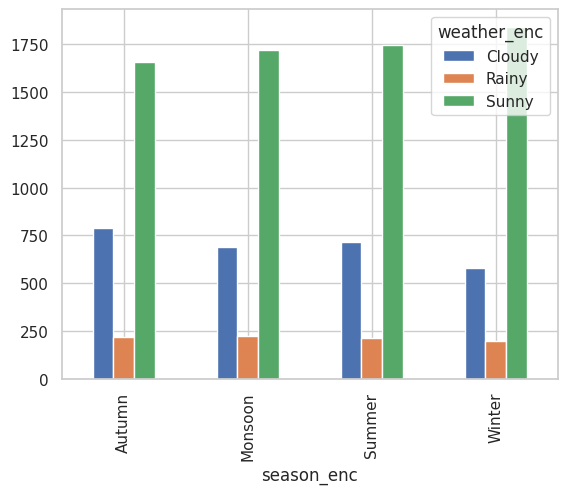

In [ ]:
contigency.plot(kind='bar')

Step 3: Decide the significance level

The significance level (α) is already set to 5% i.e., 0.05

In [ ]:
chi2, pval, dof, exp_freq = chi2_contingency(contigency, correction=False)
print('Chi-square Statistic: {} \n P-value: {} \n Degree of Freedom: {} \n Expected Frequencies: {}'.format(chi2, pval, dof, exp_freq))

Chi-square Statistic: 44.1979555965044 
 P-value: 6.753122128664597e-08 
 Degree of Freedom: 6 
 Expected Frequencies: [[ 697.34265734  213.98601399 1752.67132867]
 [ 689.22793423  211.4959365  1732.27612928]
 [ 698.65148365  214.38763939 1755.96087696]
 [ 684.77792478  210.13041013 1721.09166509]]


In [ ]:
result(pval, alpha)

As the p-value 6.753122128664597e-08 is less than the level of significance, we reject the null hypothesis.


**Observation:** Since the p-value is less than the 5% significance level, we reject the null hypothesis. Hence, we have enough statistical evidence to say that the weather conditions are dependent on the ongoing season.

# Insights from hypothesis testing -

The no. of bikes rented on weekdays is comparatively higher than on weekends.

The no. of bikes rented on regular days is comparatively higher than on holidays.

The demand of bicycles on rent differs under different weather conditions.

The demand of bicycles on rent is different during different seasons.

The weather conditions are surely dependent upon the ongoing season.



**recommendations** -

The demand of bikes on rent are usually higher during Weekdays.

The demand of bikes on rent are usually higher during Regular days.

The chances of person renting a bike are usually higher during Season 3.

The chances of person renting a bike are usually higher during Weather condition 1.

We recommend the company to maintain the bike stocks accordingly.